# SRGAN

To implement SRGAN in Python.

## Mount my drive

My google drive has train images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import data

Import data from my drive.

In [0]:
import numpy as np

DATA_NUM = 512

def get_data_path(base_dir, file_name):
  """
  To make file path for each .csv file.
  This returns a path list for each .csv file.

  Arguments:
    
    base_dir[str]: Absolute path for data
      ex) "drive/My Drive/KyotoLab/NCP_601_CG_data-set/NCP_601_CG_final_afm-image_res05x05_csv/"
  
    file_name[str]: file name of each .csv file
      ex) "NCP_601_CG_final_afm-image_res05x05"
  
  
  return:
    
    path_lst[List[str]]: paths list for each .csv file

  """
  path_lst = []
  for i in range(1, DATA_NUM+1):
    idx = ("0"*3 + str(i))[-4:]
    path = base_dir + file_name + "_" + idx + ".csv"
    path_lst.append(path)
  
  return path_lst


def parse_data(file_path):
  """
  To parse .csv file and convert to numpy array.

  Arguments:
    
    file_path[str]: Absolute file path
      ex) get_data_path(base_dir_05, file_name_05)
  

  return:

    data[numpy.ndarray]: Numpy array composed of each pixel value.
  """
  with open(file_path, mode="r") as f:
    data = np.array([np.array(list(map(lambda x: float(x), \
                                       i.split(" ")[:-1]))) \
                     for i in f.readlines()])
    
  return data



In [3]:
# For 05x05
base_dir_05 = "drive/My Drive/KyotoLab/NCP_601_CG_data-set/NCP_601_CG_final_afm-image_res05x05_csv/"
file_name_05 = "NCP_601_CG_final_afm-image_res05x05"
my_path05 = get_data_path(base_dir_05, file_name_05)

# For 10x10
#base_dir_10 = "drive/My Drive/KyotoLab/NCP_601_CG_data-set/NCP_601_CG_final_afm-image_res10x10_csv/"
#file_name_10 = "NCP_601_CG_final_afm-image_res10x10"
#my_path10 = get_data_path(base_dir_10, file_name_10)

# For 20x20
base_dir_20 = "drive/My Drive/KyotoLab/NCP_601_CG_data-set/NCP_601_CG_final_afm-image_res20x20_csv/"
file_name_20 = "NCP_601_CG_final_afm-image_res20x20"
my_path20 = get_data_path(base_dir_20, file_name_20)

data = parse_data(my_path05[10])
print(data.shape)

(60, 60)


## Show image

When parsing data, let's show the image.

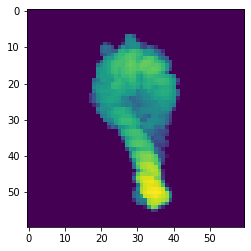

In [57]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(data, tensor=True):
  """
  To show image as graphics

  Arguments:
    
    data[numpy.ndarray or torch.cuda.tensor]

    tensor[Boolean]
  """
  if tensor:
    data = data.cpu()[310][0].detach()
    plt.imshow(data.numpy())
  
  else:
    plt.imshow(data)
  
  plt.show()


show_image(data, tensor=False)

## Neural Network class

When finishing preparing image data, now we implement Neural Network class for SRGAN

In [5]:
import torch
import torch.nn as nn 
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F

import torchvision.transforms as transforms
from torchvision.models.vgg import vgg16

# Check if the CUDA is available ?
cuda = torch.cuda.is_available()
if cuda:
  print('CUDA is available!')
else:
  print("You cannot use CUDA.")

CUDA is available!


### Generator

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channel):
    super(ResidualBlock,self).__init__()

    self.residualblock=nn.Sequential(
        nn.Conv2d(input_channel, input_channel, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(input_channel),
        nn.PReLU(),
        nn.Conv2d(input_channel, input_channel, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(input_channel)
    )
    
  def forward(self,x):
    residual = self.residualblock(x)

    return x + residual


class Pixelshuffler(nn.Module):
  def __init__(self,input_channel,r): #r=upscale_factor
    super(Pixelshuffler,self).__init__()

    self.layer=nn.Sequential(
        nn.Conv2d(input_channel,240,kernel_size=3,stride=1,padding=1), 
        nn.PixelShuffle(r),
        nn.PReLU()
    )
    
  def forward(self,x):
    
    return self.layer(x)

In [0]:
class Generator(nn.Module):
  def __init__(self, image_size):
    super(Generator,self).__init__()
    self.image_size = image_size

    self.pre_layer = nn.Sequential(
          nn.Conv2d(1, 60, kernel_size=9, stride=1, padding=4),
          nn.PReLU()
      )

    self.residual_layer = nn.Sequential(
        ResidualBlock(60),
        ResidualBlock(60),
        ResidualBlock(60),
        ResidualBlock(60),
        ResidualBlock(60)
    )

    self.middle_layer=nn.Sequential(
        nn.Conv2d(60, 60, kernel_size=3, 
                  stride=1, padding=1),
        nn.BatchNorm2d(60)
    )

    self.pixelshuffler_layer = nn.Sequential(
        Pixelshuffler(60, 2),
        Pixelshuffler(60, 2),
        nn.Conv2d(60, 1, kernel_size=9, stride=1, padding=4)
    )
    
  def forward(self,input_image):
    pre = self.pre_layer(input_image)
    res = self.residual_layer(pre)
    middle = self.middle_layer(res)
    middle = middle + pre
    output = self.pixelshuffler_layer(middle)

    return output

In [8]:
image05_tensor_lst = []
for path in my_path05:
  data_ = np.array([parse_data(path)])
  image05_tensor_lst.append(data_)

image20_tensor_lst = []
for path in my_path20:
  data_ = np.array([parse_data(path)])
  image20_tensor_lst.append(data_)

image05_tensor = torch.from_numpy(np.array(image05_tensor_lst)).float()
image20_tensor = torch.from_numpy(np.array(image20_tensor_lst)).float()

print("Image 05x05")
print("Tensor Type : ", image05_tensor.type())
print("Tensor Size : ", image05_tensor.shape)

print("\nImage 20x20")
print("Tensor Type : ", image20_tensor.type())
print("Tensor Size : ", image20_tensor.shape)

Image 05x05
Tensor Type :  torch.FloatTensor
Tensor Size :  torch.Size([512, 1, 60, 60])

Image 20x20
Tensor Type :  torch.FloatTensor
Tensor Size :  torch.Size([512, 1, 15, 15])


Output shape :  torch.Size([512, 1, 60, 60])


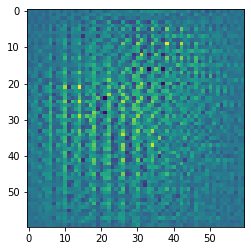

In [59]:
g = Generator(60)
if cuda:
  test_input = image20_tensor.cuda()
  g = g.cuda()

out = g(test_input).cpu()
print("Output shape : ", out.shape)

show_image(out)

#### Train Generator alone

If you train generator model alone, you have to run these cells.

In [0]:
def MSE_Loss(generated_image, hr_image):
  mse_loss = nn.MSELoss()
  image_loss = mse_loss(generated_image, hr_image)

  return image_loss

In [0]:
G_only = Generator(60)

if cuda:
  G_only = G_only.cuda()
  image05_tensor = image05_tensor.cuda()
  image20_tensor = image20_tensor.cuda()

G_optimizer =  optim.Adam(G_only.parameters(), 
                          lr=0.0001, 
                          betas=(0.9, 0.999))

In [0]:
NUM_EPOCH = 3000
Loss_acc = []

def train_snapshot():
  G_only.train()
  G_loss = 0

  for i in range(NUM_EPOCH):
    G_only.zero_grad()
    fake_image = G_only(image20_tensor)
    G_loss = MSE_Loss(fake_image, image05_tensor)
    print("Step ", i, "   Loss : ", G_loss.data.item())
    Loss_acc.append(G_loss.data.item())
    G_loss.backward()
    G_optimizer.step()

In [66]:
loss_acc = train_snapshot()

Step  0    Loss :  494.0414123535156
Step  1    Loss :  477.35809326171875
Step  2    Loss :  460.5826110839844
Step  3    Loss :  443.32476806640625
Step  4    Loss :  425.30596923828125
Step  5    Loss :  406.3362121582031
Step  6    Loss :  386.3207092285156
Step  7    Loss :  365.2912292480469
Step  8    Loss :  343.4607238769531
Step  9    Loss :  321.2901611328125
Step  10    Loss :  299.5563049316406
Step  11    Loss :  279.4084167480469
Step  12    Loss :  262.3492736816406
Step  13    Loss :  250.00418090820312
Step  14    Loss :  243.4376678466797
Step  15    Loss :  242.00149536132812
Step  16    Loss :  242.64683532714844
Step  17    Loss :  241.32606506347656
Step  18    Loss :  235.65232849121094
Step  19    Loss :  225.9165802001953
Step  20    Loss :  214.08621215820312
Step  21    Loss :  202.38339233398438
Step  22    Loss :  192.37322998046875
Step  23    Loss :  184.6639862060547
Step  24    Loss :  179.0427703857422
Step  25    Loss :  174.81753540039062
Step  26  

Input Image


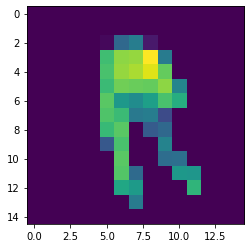

True Image


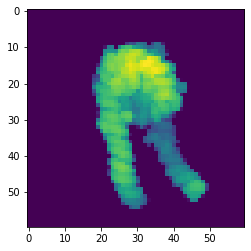

Fake Image


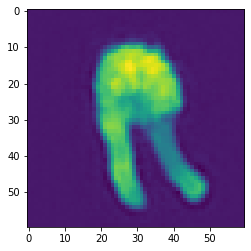

Loss Accumulation of Generator


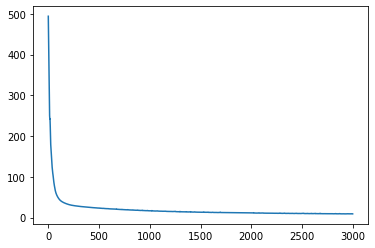

In [67]:
print("Input Image")
show_image(image20_tensor)

print("True Image")
show_image(image05_tensor)

print("Fake Image")
fake_image = G_only(image20_tensor.cuda())
show_image(fake_image)

print("Loss Accumulation of Generator")
plt.plot(Loss_acc)
plt.show()

### Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(1, 60, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(60, 60, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(60),
        nn.LeakyReLU(0.2),

        nn.Conv2d(60, 120, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(120),
        nn.LeakyReLU(0.2),

        nn.Conv2d(120, 120, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(120),
        nn.LeakyReLU(0.2),

        nn.Conv2d(120, 240, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(240),
        nn.LeakyReLU(0.2),

        nn.Conv2d(240, 240, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(240),
        nn.LeakyReLU(0.2),

        nn.Conv2d(240, 480, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(480),
        nn.LeakyReLU(0.2),

        nn.Conv2d(480,480,kernel_size=3,stride=2,padding=1),
        nn.BatchNorm2d(480),
        nn.LeakyReLU(0.2)
    ) 

    self.dense_layer = nn.Sequential(
        nn.Linear(7680,960),
        nn.LeakyReLU(0.2),
        nn.Linear(960,1),
        nn.Sigmoid()
    )

  def forward(self,input_image):
    batch_size = input_image.size()[0]

    conv = self.conv_layers(input_image)
    reshape = conv.view(batch_size,-1)
    output = self.dense_layer(reshape)

    return output

In [11]:
test_input = torch.ones(10,1,60,60)  # 10 pictures
d = Discriminator()
if cuda:
  test_input = test_input.cuda()
  d = d.cuda()

out = d(test_input)
print(out.size())
out = d(image05_tensor[[0, 20, 334]].cuda())
print(out.size())

torch.Size([10, 1])
torch.Size([3, 1])


## Loss function

In [0]:
def generator_loss(fake_image, real_image, d_label, t_label):
  vgg = vgg16(pretrained=True)
  content_layers = nn.Sequential(*list(vgg.features)[:31]).cuda().eval()
  for param in content_layers.parameters():
      param.requires_grad=False

  mse_loss = nn.MSELoss()
  fake_images = torch.tensor(np.array([fake_image.cpu().detach().numpy()]*3).reshape(16, -1, 60, 60))
  real_images = torch.tensor(np.array([real_image.cpu().detach().numpy()]*3).reshape(16, -1, 60, 60))

  if cuda:
    fake_images = fake_images.cuda()
    real_images = real_images.cuda()

  content_loss = mse_loss(content_layers(fake_images), content_layers(real_images))

  BCE_loss = nn.BCELoss()
  adversarial_loss = BCE_loss(d_label, t_label)

  return content_loss+0.001*adversarial_loss

## Train

In [0]:
G = Generator(60)
D = Discriminator()

if cuda:
  G = G.cuda()
  D = D.cuda()

  #g_param = torch.load("asset/G.pth")
  #G.load_state_dict(g_param)

G_optimizer = optim.Adam(G.parameters(),lr=0.0001,betas=(0.9,0.999))
D_optimizer = optim.Adam(D.parameters(),lr=0.0001,betas=(0.9,0.999))

d_loss = nn.BCELoss()

In [0]:
BATCH_SIZE = 16

G_loss_acc = np.array([])
D_loss_acc = np.array([])

def train():
  D.train()
  G.train()

  y_real=torch.ones(BATCH_SIZE, 1)
  y_fake=torch.zeros(BATCH_SIZE, 1)

  if cuda:
    y_real=y_real.cuda()
    y_fake=y_fake.cuda()
  
  batch_index = np.random.randint(0, DATA_NUM-1, BATCH_SIZE)
  real05_images = image05_tensor[batch_index]
  real20_images = image20_tensor[batch_index]
  if cuda:
    real05_images = real05_images.cuda()
    real20_images = real20_images.cuda()
  
  fake_images = G(real20_images)

  # Train Descriminator
  D.zero_grad()
  
  D_real_out = D(real05_images)
  D_real_loss = d_loss(D_real_out, y_real)
  D_fake_out = D(fake_images)
  D_fake_loss = d_loss(D_fake_out, y_fake)

  D_loss = D_real_loss + D_fake_loss
  D_loss.backward(retain_graph=True)
  D_optimizer.step()
  
  # Train Generator
  G.zero_grad()

  G_loss = generator_loss(fake_images, real05_images, D_fake_out, y_real)
  G_loss.backward()
  G_optimizer.step()

  return D_loss, G_loss

In [30]:
EPOCH_NUM = 1000

#D_loss_acc = np.array([])
#G_loss_acc = np.array([])

for epoch in range(EPOCH_NUM):
  d_, g_ = train()
  d_tmp = d_.sum().detach().cpu().numpy()
  g_tmp = g_.sum().detach().cpu().numpy()
  print("Epoch: ",epoch, "   D_loss: ", d_tmp, "   G_loss: ", g_tmp)
  D_loss_acc = np.append(D_loss_acc, d_tmp)
  G_loss_acc = np.append(G_loss_acc, g_tmp)

Epoch:  0    D_loss:  0.0076658856    G_loss:  315.28168
Epoch:  1    D_loss:  0.00031587936    G_loss:  400.43857
Epoch:  2    D_loss:  0.00033090095    G_loss:  383.9573
Epoch:  3    D_loss:  7.4387644e-05    G_loss:  345.10062
Epoch:  4    D_loss:  0.023247594    G_loss:  325.11035
Epoch:  5    D_loss:  0.0013195439    G_loss:  349.1238
Epoch:  6    D_loss:  0.0003292701    G_loss:  290.636
Epoch:  7    D_loss:  0.0008253443    G_loss:  323.82248
Epoch:  8    D_loss:  0.029119898    G_loss:  316.47217
Epoch:  9    D_loss:  0.00033515668    G_loss:  232.16019
Epoch:  10    D_loss:  5.226668e-05    G_loss:  260.07785
Epoch:  11    D_loss:  0.00010229253    G_loss:  298.9899
Epoch:  12    D_loss:  0.0011606397    G_loss:  227.08559
Epoch:  13    D_loss:  0.0009787196    G_loss:  271.98257
Epoch:  14    D_loss:  0.000278779    G_loss:  220.15213
Epoch:  15    D_loss:  0.00019913286    G_loss:  231.07889
Epoch:  16    D_loss:  0.00084298936    G_loss:  248.4899
Epoch:  17    D_loss:  0.0

### Check generated image

Input Image


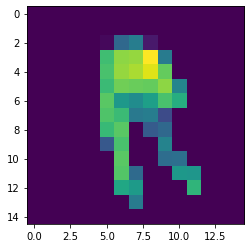

True Image


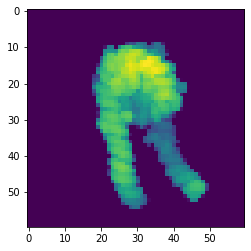

Fake Image


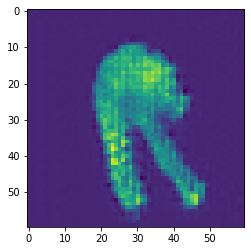

Loss Accumulation of Generator


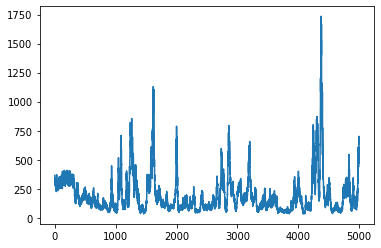

In [69]:
print("Input Image")
show_image(image20_tensor)

print("True Image")
show_image(image05_tensor)

print("Fake Image")
fake_image = G(image20_tensor.cuda())
show_image(fake_image)

print("Loss Accumulation of Generator")
plt.plot(G_loss_acc)
plt.show()

## Save Model

In [0]:
import pickle

with open("./drive/My Drive/KyotoLab/Models/generator_only_3000.pickle", mode="wb") as f:
  pickle.dump(G_only, f)

with open("./drive/My Drive/KyotoLab/Models/generator_5000.pickle", mode="wb") as f:
  pickle.dump(G, f)

with open("./drive/My Drive/KyotoLab/Models/discriminator_5000.pickle", mode="wb") as f:
  pickle.dump(D, f)